In [1]:
from __future__ import print_function
import importlib
resources = importlib.import_module("resources")
import resources.MonteCarlo as MC

import numpy as np
import pandas as pd
import random
my_seed = 2010
random.seed(my_seed)

import matplotlib.pyplot as plt
%matplotlib inline 

import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR


import keras
import tensorflow as tf
from keras.layers import Dense, BatchNormalization, Multiply, Lambda, LeakyReLU
from keras.models import Model
from keras.initializers import RandomNormal, RandomUniform
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.constraints import NonNeg
from keras import backend as K

Using TensorFlow backend.


In [2]:
#Import Data
Data = pd.read_csv('data/preprocessedlosAngParking/part-00000-a8814381-7490-4ac5-8769-145ad7e2824a-c000.csv').sample(frac = 1/5e1)
Data['SN'] = pd.to_numeric(Data['SN'], errors ='coerce')
Data['position'] = pd.to_numeric(Data['position'], errors ='coerce')
Data = Data[['SN','position']]
Data.dropna()
Data = Data[Data['SN'] > 1.3e9]
scalar = StandardScaler()
Data[['SN','position']] = scalar.fit_transform(Data.values)
X = Data.values
db = hdbscan.HDBSCAN( min_samples=1000).fit(X)
Data['Labels'] = db.labels_
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
del db
del X

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarnin

In [3]:
batch_size = 256
epochs = 6000
lambd  = 1e-6
no_output_range = [1]
no_input = 1
models = []
final_score = 0

def customLoss(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return K.max(K.abs(yTrue -yPred))

def customMetric(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return K.max(K.min(K.abs(yTrue -yPred),axis = 1))


for i in range(n_clusters_):
    X_i = Data[Data['Labels']==i]['SN'].values.reshape(-1, 1)
    print(X_i.shape)
    Y_i = Data[Data['Labels']==i]['position'].values
    _input_= keras.layers.Input(shape=(no_input,))
    l1 = Dense(1, activation='linear', name="hidden_1_dense64",
                        kernel_initializer= RandomUniform(minval=.05, maxval=.1),
                        bias_initializer=RandomUniform(),
                        input_shape=[no_input])(_input_)   
    l1a = l1 #LeakyReLU(alpha=0.1,name="hidden_3_leakyRelu")(l1)

    _output_ = l1a
    model = keras.models.Model(inputs=_input_ , outputs=_output_)
    opt = keras.optimizers.SGD(lr=.01, decay=1e-5)
    model.compile(loss=customLoss, metrics=[], optimizer=opt)

    filepath = "results\parking_weights_cluster{}_linear.hdf5".format(i)
    model.fit(X_i, Y_i,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[],
          verbose=0)
    score = model.evaluate(X_i, Y_i, verbose=0)
    print(score)
    final_score = max(final_score,score)
    models.append(model)
print(final_score)

(5491, 1)
0.12164171893530216
(13834, 1)
0.18315273510405003
(23379, 1)
0.19181339154063373
(79309, 1)
0.2874689992563688
(28663, 1)
0.1402227577168149
(11785, 1)
0.13929353876037015
0.2874689992563688


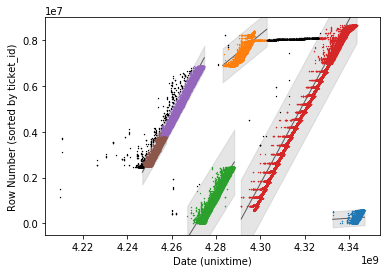

In [16]:
X_space = np.linspace(-2, 2, 400).reshape(-1,1)
means = scalar.mean_
std_dev = scalar.scale_

plt.ylabel("Row Number (sorted by ticket_id)")
plt.xlabel("Date (unixtime)")
plt.ylim(-.05e7,.9e7)

for i in range(n_clusters_):
    X_i = Data[Data['Labels']==i]['SN'].values.reshape(-1, 1)
    Y_i = Data[Data['Labels']==i]['position'].values
    plt.scatter(X_i*std_dev[0]+means[0], Y_i*std_dev[1]+means[1],s = .2,marker= '^',zorder=2)
    model = models[i]
    max_error = 0
    for i in range(Y_i.shape[0]):
        max_error = max(max_error,abs(Y_i[i]-model.predict(X_i[i])[0,0]))
    X_space =  np.linspace(np.min(X_i),np.max(X_i),400).reshape(-1,1)
    Y_pred = model.predict(X_space)
    plt.plot(X_space*std_dev[0]+means[0],Y_pred*std_dev[1]+means[1],'k',linewidth = 1, alpha = .6,zorder=1)
    plt.fill_between(X_space[:,0]*std_dev[0]+means[0],
                     (Y_pred[:,0] - max_error)*std_dev[1]+means[1],
                     (Y_pred[:,0] + max_error)*std_dev[1]+means[1],
                     color='gray', alpha=0.2)

X_i = Data[Data['Labels']==-1]['SN'].values.reshape(-1, 1)
Y_i = Data[Data['Labels']==-1]['position'].values

plt.scatter(X_i*std_dev[0]+means[0], Y_i*std_dev[1]+means[1],color = 'k',s = .2,marker= '^',zorder=2)
    
plt.savefig("results/Test_Parking_Cluster_SVR_{number}.jpg".format(number = n_clusters_))



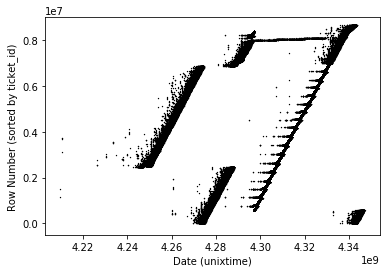

In [15]:
plt.ylabel("Row Number (sorted by ticket_id)")
plt.xlabel("Date (unixtime)")
plt.ylim(-.05e7,.9e7)

X_i = Data['SN'].values
Y_i = Data['position'].values
plt.scatter(X_i*std_dev[0]+means[0], Y_i*std_dev[1]+means[1],color = 'k',s = .2,marker= '^',zorder=2)
    
plt.savefig("results/Test_Parking_Cluster_SVR_{number}.jpg".format(number = n_clusters_))



In [18]:
len(Data[Data['Labels'] == -1])/len(Data)

0.009263324795706794

In [ ]:
week = 604800 # length of one week in unix time